## Lab 8.01 Neural Network Binary Classification
_By: Jeff Hale_

This lab uses a small [dataset](https://archive.ics.uci.edu/ml/datasets/heart+Disease) provided by the Cleveland Clinic Foundation for Heart Disease. The goal is to predict whether a patient has heart disease (the *target* column).

We suggest running this lab in [Google Colab](https://colab.research.google.com/). 

Go *File*->*Upload notebook* to upload this notebook to colab.

If you are working in Colab and want to see if you can get a speed boost, set your runtime to *TPU* by going to *Runtime* -> *Change runtime type* in the menu above. 

The processor type won't make a big difference with this small dataset and small networks, but it's good to know how to change the processor.

### Read data and load using pandas

#### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split, cross_val_score
import category_encoders as ce
from sklearn.datasets import make_classification, make_regression
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
import seaborn as sns
np.random.seed(2)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import explained_variance_score, mean_squared_error
# Import metrics.
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from keras import optimizers

In [3]:
csv_file = pd.read_csv('./data/heart.csv')

#### Load the csv file using pandas

In [4]:
csv_file.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


#### Inspect

In [5]:
# Data doesn't have any missed values
csv_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        303 non-null    int64  
 1   Sex        303 non-null    int64  
 2   ChestPain  303 non-null    object 
 3   RestBP     303 non-null    int64  
 4   Chol       303 non-null    int64  
 5   Fbs        303 non-null    int64  
 6   RestECG    303 non-null    int64  
 7   MaxHR      303 non-null    int64  
 8   ExAng      303 non-null    int64  
 9   Oldpeak    303 non-null    float64
 10  Slope      303 non-null    int64  
 11  Ca         299 non-null    float64
 12  Thal       301 non-null    object 
 13  AHD        303 non-null    object 
dtypes: float64(2), int64(9), object(3)
memory usage: 33.3+ KB


In [6]:
csv_file.isnull().sum()

Age          0
Sex          0
ChestPain    0
RestBP       0
Chol         0
Fbs          0
RestECG      0
MaxHR        0
ExAng        0
Oldpeak      0
Slope        0
Ca           4
Thal         2
AHD          0
dtype: int64

In [7]:
csv_file['Ca'].fillna(int(csv_file['Ca'].mean()), inplace=True)
csv_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        303 non-null    int64  
 1   Sex        303 non-null    int64  
 2   ChestPain  303 non-null    object 
 3   RestBP     303 non-null    int64  
 4   Chol       303 non-null    int64  
 5   Fbs        303 non-null    int64  
 6   RestECG    303 non-null    int64  
 7   MaxHR      303 non-null    int64  
 8   ExAng      303 non-null    int64  
 9   Oldpeak    303 non-null    float64
 10  Slope      303 non-null    int64  
 11  Ca         303 non-null    float64
 12  Thal       301 non-null    object 
 13  AHD        303 non-null    object 
dtypes: float64(2), int64(9), object(3)
memory usage: 33.3+ KB


In [8]:
 # Data doesn't have any missed values
csv_file['Thal'].fillna(str(csv_file['Thal'].mode()), inplace=True)
csv_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        303 non-null    int64  
 1   Sex        303 non-null    int64  
 2   ChestPain  303 non-null    object 
 3   RestBP     303 non-null    int64  
 4   Chol       303 non-null    int64  
 5   Fbs        303 non-null    int64  
 6   RestECG    303 non-null    int64  
 7   MaxHR      303 non-null    int64  
 8   ExAng      303 non-null    int64  
 9   Oldpeak    303 non-null    float64
 10  Slope      303 non-null    int64  
 11  Ca         303 non-null    float64
 12  Thal       303 non-null    object 
 13  AHD        303 non-null    object 
dtypes: float64(2), int64(9), object(3)
memory usage: 33.3+ KB


#### Check the value counts of the columns that are objects

In [9]:
csv_file.value_counts(normalize=True).head()

Age  Sex  ChestPain     RestBP  Chol  Fbs  RestECG  MaxHR  ExAng  Oldpeak  Slope  Ca   Thal        AHD
29   1    nontypical    130     204   0    2        202    0      0.0      1      0.0  normal      No     0.0033
59   1    typical       134     204   0    0        162    0      0.8      1      2.0  normal      Yes    0.0033
          nonanginal    150     212   1    0        157    0      1.6      1      0.0  normal      No     0.0033
                        126     218   1    0        134    0      2.2      2      1.0  fixed       Yes    0.0033
          asymptomatic  170     326   0    2        140    1      3.4      3      0.0  reversable  Yes    0.0033
dtype: float64

You could load data into a format for TensorFlow using `tf.data.Dataset`, but these are unwieldly - it's a serious pain to create a validation dataset from a TF dataset. You used to have to make your data into NumPy arrays for TensorFlow. Now you can just keep them as pandas DataFrames!

#### Set up X and y
Convert `ChestPain`, `Thal`, and `AHD` (the target) columns to numeric.
To convert features to numeric, feel free to give this friendlier OHE a try:
```
!pip install category_encoders 
import category_encoders as ce
```

In [10]:
csv_file['Target_AHD']=csv_file['AHD'].apply(lambda x: 1 if x=='Yes' else 0)

In [11]:
csv_file.head(2)

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD,Target_AHD
0,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No,0
1,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes,1


In [12]:
pd.get_dummies(csv_file, columns=['ChestPain', 'Thal']).head()

,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,...,AHD,Target_AHD,ChestPain_asymptomatic,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,Thal_0 normal\ndtype: object,Thal_fixed,Thal_normal,Thal_reversable
0,63,1,145,233,1,2,150,0,2.3,3,...,No,0,0,0,0,1,0,1,0,0
1,67,1,160,286,0,2,108,1,1.5,2,...,Yes,1,1,0,0,0,0,0,1,0
2,67,1,120,229,0,2,129,1,2.6,2,...,Yes,1,1,0,0,0,0,0,0,1
3,37,1,130,250,0,0,187,0,3.5,3,...,No,0,0,1,0,0,0,0,1,0
4,41,0,130,204,0,2,172,0,1.4,1,...,No,0,0,0,1,0,0,0,1,0


#### Train-test split

In [13]:
# Drop the string values columns and assign the X and Y value
X = csv_file.drop(columns=['Target_AHD', 'AHD', 'ChestPain', 'Thal'])
y = csv_file['Target_AHD']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [15]:
# Scale data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#### Set the TensorFlow random seed

In [16]:
n_input = X_train.shape[1]

In [17]:
X_test = np.array(X_test)

In [18]:
X_train = np.array(X_train)

In [19]:
n_input

11

In [20]:
np.random.seed([3,1415])

## Create and train a model

#### Create model structure

In [21]:
model = Sequential()

In [22]:
model.add(Dense(17, input_dim=n_input, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [23]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc']) # loss = 'bce'

In [24]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=None,
    verbose=2
)

Epoch 1/100
8/8 - 0s - loss: 0.7212 - acc: 0.3877 - val_loss: 0.6931 - val_acc: 0.5395
Epoch 2/100
8/8 - 0s - loss: 0.7082 - acc: 0.4229 - val_loss: 0.6851 - val_acc: 0.5921
Epoch 3/100
8/8 - 0s - loss: 0.6981 - acc: 0.4449 - val_loss: 0.6775 - val_acc: 0.5789
Epoch 4/100
8/8 - 0s - loss: 0.6897 - acc: 0.4802 - val_loss: 0.6706 - val_acc: 0.5526
Epoch 5/100
8/8 - 0s - loss: 0.6821 - acc: 0.5022 - val_loss: 0.6637 - val_acc: 0.5658
Epoch 6/100
8/8 - 0s - loss: 0.6751 - acc: 0.5330 - val_loss: 0.6573 - val_acc: 0.5789
Epoch 7/100
8/8 - 0s - loss: 0.6687 - acc: 0.5683 - val_loss: 0.6514 - val_acc: 0.6053
Epoch 8/100
8/8 - 0s - loss: 0.6632 - acc: 0.5859 - val_loss: 0.6448 - val_acc: 0.6184
Epoch 9/100
8/8 - 0s - loss: 0.6576 - acc: 0.6035 - val_loss: 0.6381 - val_acc: 0.6447
Epoch 10/100
8/8 - 0s - loss: 0.6515 - acc: 0.6123 - val_loss: 0.6324 - val_acc: 0.6842
Epoch 11/100
8/8 - 0s - loss: 0.6457 - acc: 0.6300 - val_loss: 0.6262 - val_acc: 0.6974
Epoch 12/100
8/8 - 0s - loss: 0.6394 - ac

Epoch 95/100
8/8 - 0s - loss: 0.3262 - acc: 0.8590 - val_loss: 0.3453 - val_acc: 0.8289
Epoch 96/100
8/8 - 0s - loss: 0.3256 - acc: 0.8590 - val_loss: 0.3437 - val_acc: 0.8421
Epoch 97/100
8/8 - 0s - loss: 0.3243 - acc: 0.8634 - val_loss: 0.3424 - val_acc: 0.8421
Epoch 98/100
8/8 - 0s - loss: 0.3229 - acc: 0.8634 - val_loss: 0.3416 - val_acc: 0.8553
Epoch 99/100
8/8 - 0s - loss: 0.3211 - acc: 0.8678 - val_loss: 0.3402 - val_acc: 0.8553
Epoch 100/100
8/8 - 0s - loss: 0.3203 - acc: 0.8678 - val_loss: 0.3393 - val_acc: 0.8553


#### Visualize the structure

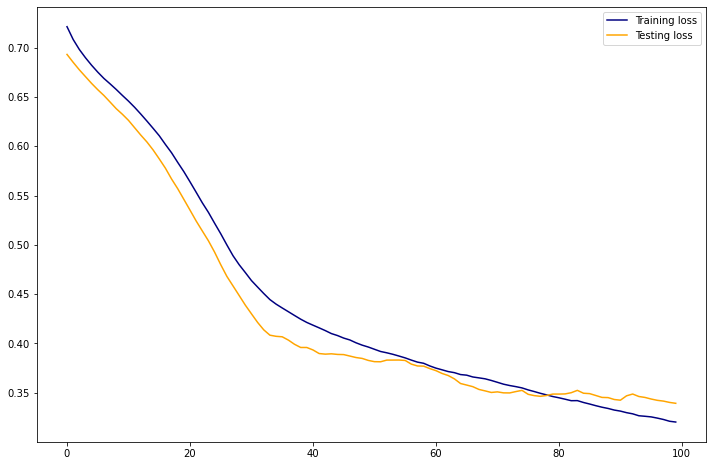

In [25]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='orange')
plt.legend();

#### Compile

In [26]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

In [27]:
history.history['acc'][-1], history.history['val_acc'][-1]

(0.8678414225578308, 0.8552631735801697)

#### Make an EarlyStopping callback

In [28]:
# Code adopted from class examples
from tensorflow.keras.callbacks import EarlyStopping

model_es = Sequential()

n_input = X_train.shape[1]

model_es.add(Dense(17, input_dim=n_input, activation='relu'))
model_es.add(Dense(10, activation='relu'))
model_es.add(Dense(1, activation='sigmoid'))

model_es.compile(loss='bce', optimizer='adam', metrics=['acc'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, 
                           verbose=1, mode='auto')

history_es = model_es.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=None,
    callbacks=[early_stop]
)

Epoch 1/100
8/8 [==============================] - 0s 8ms/step - loss: 0.6836 - acc: 0.5286 - val_loss: 0.6155 - val_acc: 0.6579
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6580 - acc: 0.5947 - val_loss: 0.5941 - val_acc: 0.7105
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6375 - acc: 0.6300 - val_loss: 0.5750 - val_acc: 0.7500
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6178 - acc: 0.6608 - val_loss: 0.5552 - val_acc: 0.7500
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 0.5998 - acc: 0.6828 - val_loss: 0.5378 - val_acc: 0.7895
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 0.5829 - acc: 0.7048 - val_loss: 0.5202 - val_acc: 0.8158
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 0.5661 - acc: 0.7093 - val_loss: 0.5029 - val_acc: 0.8421
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 0.5496 - acc: 0.7313 - val

#### Fit the model

In [29]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=60,
    batch_size=None,
    verbose=2
)

Epoch 1/60
8/8 - 0s - loss: 0.3209 - accuracy: 0.8634 - val_loss: 0.3387 - val_accuracy: 0.8553
Epoch 2/60
8/8 - 0s - loss: 0.3177 - accuracy: 0.8634 - val_loss: 0.3375 - val_accuracy: 0.8553
Epoch 3/60
8/8 - 0s - loss: 0.3157 - accuracy: 0.8634 - val_loss: 0.3357 - val_accuracy: 0.8553
Epoch 4/60
8/8 - 0s - loss: 0.3142 - accuracy: 0.8634 - val_loss: 0.3341 - val_accuracy: 0.8553
Epoch 5/60
8/8 - 0s - loss: 0.3129 - accuracy: 0.8590 - val_loss: 0.3329 - val_accuracy: 0.8553
Epoch 6/60
8/8 - 0s - loss: 0.3119 - accuracy: 0.8546 - val_loss: 0.3345 - val_accuracy: 0.8553
Epoch 7/60
8/8 - 0s - loss: 0.3105 - accuracy: 0.8634 - val_loss: 0.3360 - val_accuracy: 0.8421
Epoch 8/60
8/8 - 0s - loss: 0.3099 - accuracy: 0.8634 - val_loss: 0.3363 - val_accuracy: 0.8421
Epoch 9/60
8/8 - 0s - loss: 0.3090 - accuracy: 0.8634 - val_loss: 0.3369 - val_accuracy: 0.8421
Epoch 10/60
8/8 - 0s - loss: 0.3082 - accuracy: 0.8634 - val_loss: 0.3386 - val_accuracy: 0.8421
Epoch 11/60
8/8 - 0s - loss: 0.3070 - a

In [30]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=None, epochs=60)

Epoch 1/60
8/8 [==============================] - 0s 4ms/step - loss: 0.2586 - accuracy: 0.8899 - val_loss: 0.3283 - val_accuracy: 0.8684
Epoch 2/60
8/8 [==============================] - 0s 2ms/step - loss: 0.2572 - accuracy: 0.8943 - val_loss: 0.3312 - val_accuracy: 0.8684
Epoch 3/60
8/8 [==============================] - 0s 2ms/step - loss: 0.2568 - accuracy: 0.8987 - val_loss: 0.3342 - val_accuracy: 0.8684
Epoch 4/60
8/8 [==============================] - 0s 2ms/step - loss: 0.2552 - accuracy: 0.8987 - val_loss: 0.3347 - val_accuracy: 0.8684
Epoch 5/60
8/8 [==============================] - 0s 2ms/step - loss: 0.2544 - accuracy: 0.8987 - val_loss: 0.3369 - val_accuracy: 0.8684
Epoch 6/60
8/8 [==============================] - 0s 2ms/step - loss: 0.2541 - accuracy: 0.8987 - val_loss: 0.3377 - val_accuracy: 0.8684
Epoch 7/60
8/8 [==============================] - 0s 2ms/step - loss: 0.2530 - accuracy: 0.8987 - val_loss: 0.3382 - val_accuracy: 0.8684
Epoch 8/60
8/8 [==================

8/8 [==============================] - 0s 3ms/step - loss: 0.2046 - accuracy: 0.9251 - val_loss: 0.3620 - val_accuracy: 0.8553


#### Plot model performance on the validation data (accuracy, recall, and precision)

In [33]:
pred = model.predict(X_test)

In [35]:
# error pop up 
cm = confusion_matrix(y_test, pred)

In [38]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, pred), display_labels=['True', 'Predicted']);
disp.plot();

In [40]:
print(classification_report(y_test, pred))

#### Save model

In [41]:
#Saving the model values
pd.DataFrame(pred).to_csv("data/model.csv", index=False)

#### Load model

In [43]:
df_model = pd.read_csv('./data/model.csv')

#### Evaluate on test set 

In [45]:
tf_yp_test = model.predict(X_test)

tf_yp_test;

#### X_test predictions

In [46]:
np.sqrt(mean_squared_error(y_test, tf_yp_test))

0.33412632019806293

In [47]:
pred = model.predict(X_test)
pred

array([[0.37701815],
       [0.44517618],
       [0.235849  ],
       [0.9651015 ],
       [0.9157842 ],
       [0.08136529],
       [0.9767122 ],
       [0.97855616],
       [0.05470872],
       [0.2069307 ],
       [0.11060244],
       [0.8986444 ],
       [0.68864214],
       [0.9949038 ],
       [0.0081518 ],
       [0.99081486],
       [0.45526525],
       [0.9999212 ],
       [0.9891494 ],
       [0.97011375],
       [0.9887346 ],
       [0.04999489],
       [0.9603392 ],
       [0.69225043],
       [0.48866382],
       [0.989284  ],
       [0.4943941 ],
       [0.00809392],
       [0.9626577 ],
       [0.36332852],
       [0.07009003],
       [0.97271585],
       [0.02273044],
       [0.4369608 ],
       [0.02737698],
       [0.08988747],
       [0.99375105],
       [0.01776585],
       [0.9575529 ],
       [0.8055052 ],
       [0.9931494 ],
       [0.954514  ],
       [0.02411273],
       [0.28026116],
       [0.75933874],
       [0.97279215],
       [0.08562592],
       [0.172

#### What do those numbers look like? Let's get rid of that exponential notation and just round the predictions.

In [48]:
# It is possible to round the number with differnt rounding digit by round(model.predict(X_test),2)

#### How is the model performing? 
Let's look at the confusion matrix using TF.

In [49]:
# Evaluating confusion matric
res = tf.math.confusion_matrix(y_test, pred)
 
# Printing the result
print('Confusion_matrix: ',res)

Confusion_matrix:  tf.Tensor(
[[41  0]
 [35  0]], shape=(2, 2), dtype=int32)


Or just use sklearn's confusion matrix. 

### Make a null model

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 17)                204       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                180       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 395
Trainable params: 395
Non-trainable params: 0
_________________________________________________________________


## Can you make a better model?

Change the model architecture and see if you can make a better model. Add nodes, dense layers, and dropout layers.

In [51]:
model = Sequential()
model.add(Dense(17, input_dim=n_input, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [52]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [53]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=None, epochs=60)

Epoch 1/60
8/8 [==============================] - 0s 9ms/step - loss: 0.2479 - mae: 0.4827 - val_loss: 0.2178 - val_mae: 0.4557
Epoch 2/60
8/8 [==============================] - 0s 2ms/step - loss: 0.2439 - mae: 0.4778 - val_loss: 0.2122 - val_mae: 0.4491
Epoch 3/60
8/8 [==============================] - 0s 2ms/step - loss: 0.2317 - mae: 0.4677 - val_loss: 0.2075 - val_mae: 0.4437
Epoch 4/60
8/8 [==============================] - 0s 2ms/step - loss: 0.2237 - mae: 0.4585 - val_loss: 0.2031 - val_mae: 0.4383
Epoch 5/60
8/8 [==============================] - 0s 2ms/step - loss: 0.2268 - mae: 0.4613 - val_loss: 0.1993 - val_mae: 0.4336
Epoch 6/60
8/8 [==============================] - 0s 0s/step - loss: 0.2139 - mae: 0.4471 - val_loss: 0.1959 - val_mae: 0.4291
Epoch 7/60
8/8 [==============================] - 0s 2ms/step - loss: 0.2166 - mae: 0.4472 - val_loss: 0.1927 - val_mae: 0.4249
Epoch 8/60
8/8 [==============================] - 0s 2ms/step - loss: 0.2123 - mae: 0.4416 - val_loss: 0.

In [54]:
best_model = model.predict(X_test)
best_model;

#### Save your best model. 


In [55]:
#Saving the best predicted model values
pd.DataFrame(pred).to_csv("data/best_model.csv", index=False)

#### Compare with other algorithms
Compare your best neural net model to a scikit-learn LogisticRegression model. Also try a GradientBoostingClassifier.

#### Scale/Standardize for Logistic Regression


In [56]:
# The data is already standared above 
from sklearn.linear_model import LogisticRegression
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.3)

#### Logistic Regression

In [57]:
model = LogisticRegression()

In [58]:
model.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [59]:
model.score(X_test, y_test)

0.8131868131868132

In [60]:
model.score(X_train, y_train)

0.8160377358490566

#### Evaluate performance on metrics other than accuracy

In [61]:
predicted = model.predict(X_test)

In [62]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predicted)
cm

array([[43,  6],
       [11, 31]], dtype=int64)

Text(69.0, 0.5, 'Truth')

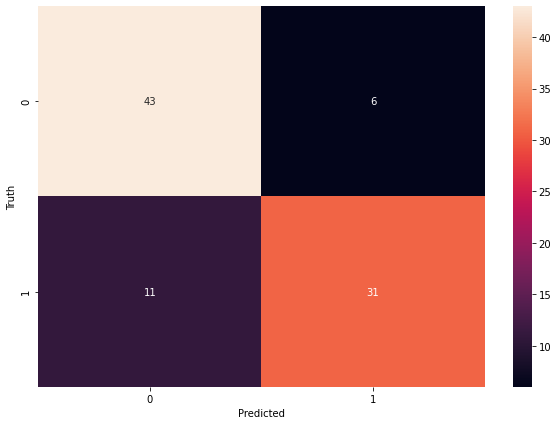

In [63]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

### GradientBoosting

In [64]:
gcb =GradientBoostingClassifier()
gcb.fit(X_train, y_train)

GradientBoostingClassifier()

In [65]:
cross_val_score(gcb, X_train, y_train, cv = 5).mean()

0.7312292358803987

In [66]:
gcb.score(X_train, y_train)

0.9952830188679245

In [67]:
gcb.score(X_test, y_test)

0.8681318681318682

#### Evaluate performance on metrics other than accuracy

In [68]:
pred =gcb.predict(X_test)

In [69]:
ac=accuracy_score(y_test, pred)
ac

0.8681318681318682

In [70]:
from sklearn.metrics import confusion_matrix
cm= confusion_matrix(y_test, pred)
cm

array([[44,  5],
       [ 7, 35]], dtype=int64)

<AxesSubplot:>

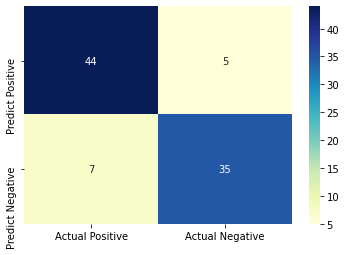

In [71]:
cm_matrix =pd.DataFrame(data=cm, columns= ['Actual Positive', 'Actual Negative'], index = ['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot = True, fmt= 'd', cmap='YlGnBu')

#### Which evaluation metric(s) are best to use in this problem? and What model do you recommend?

Logistic regression is better for this problem since the model perform about 81% accuracy without any overfitting. I recommend to use Logistic regression for this problem.

In [72]:
%pwd

'C:\\Users\\SolAti\\Documents\\GA-Data\\DSI\\Labs-assignments\\week8\\Lab8\\8.01-lab-neural-net-classification'